In [1]:
%run "./00 Logon.ipynb"

In [2]:
cchc.connection.isconnected()

True

In [3]:
import geopandas
import contextily as ctx

## Create hana_ml graph from existing SAP HANA graph workspace

In [4]:
import hana_ml.graph.hana_graph

In [5]:
hana_ml.graph.hana_graph.discover_graph_workspaces(cchc)

,SCHEMA_NAME,WORKSPACE_NAME,IS_VALID,EDGE_SCHEMA_NAME,EDGE_TABLE_NAME,EDGE_KEY_COLUMN_NAME,EDGE_SOURCE_COLUMN_NAME,EDGE_TARGET_COLUMN,VERTEX_SCHEMA_NAME,VERTEX_TABLE_NAME,VERTEX_KEY_COLUMN_NAME
0,HANAML,AIRROUTES_DFH,TRUE,HANAML,ROUTES_VIEW,ID,FROM,TO,HANAML,PORTS_VIEW,ID


In [6]:
# Create HANA Graph in Python from an exisiting graph space in SAP HANA
hgws_airroutes=(
    hana_ml.graph.hana_graph
    .create_hana_graph_from_existing_workspace(
        cchc,
        workspace_name='AIRROUTES_DFH')
)

### HANA DataFrame with geospatial strings for connections

In [7]:
dfh_ports=cchc.table("PORTS", geo_cols={"POINT_LON_LAT_GEO":"4326"})
dfh_routes=cchc.table("ROUTES")

In [8]:
dfh_routes_strings=cchc.sql(
    dfh_routes.alias('E')
    .join(dfh_ports.alias('F'),'E."FROM"=F."ID"', select=['E.*',('POINT_LON_LAT_GEO','POINT_FROM')])
    .alias('E2')
    .join(dfh_ports.alias('T'),'E2."TO"=T."ID"', 
                            select=[('E2.ID','ID'), 'FROM', 'TO', 'DIST',
                                    ('ST_MakeLine("POINT_FROM", "POINT_LON_LAT_GEO")', 'LINE')]
         ).select_statement, geo_cols={'LINE': 4326}
)

dfh_routes_strings.head(3).collect()

,ID,FROM,TO,DIST,LINE
0,5130,1,51,4381.0,LINESTRING (-84.4281005859375 33.6366996765137...
1,5131,1,52,4600.0,LINESTRING (-84.4281005859375 33.6366996765137...
2,5164,1,161,5742.0,LINESTRING (-84.4281005859375 33.6366996765137...


In [9]:
dfh_routes_strings.select(
    "*",
    ('ROUND("LINE".ST_Length(\'foot\')/5280)', "CONV_M"),
    ('ROUND("LINE".ST_Length(\'kilometer\'))', "CONV_KM")
).head(3).collect()

,ID,FROM,TO,DIST,LINE,CONV_M,CONV_KM
0,5130,1,51,4381.0,LINESTRING (-84.4281005859375 33.6366996765137...,4394.0,7072.0
1,5131,1,52,4600.0,LINESTRING (-84.4281005859375 33.6366996765137...,4614.0,7426.0
2,5164,1,161,5742.0,LINESTRING (-84.4281005859375 33.6366996765137...,5759.0,9268.0


In [10]:
cchc.table("ST_UNITS_OF_MEASURE", schema="PUBLIC").collect()

,OWNER_NAME,UNIT_NAME,UNIT_TYPE,CONVERSION_FACTOR
0,SYS,50_Kilometers,LINEAR,50000.000000
1,SYS,kilometer,LINEAR,1000.000000
2,SYS,Clarke's yard,LINEAR,0.914392
3,SYS,degree,ANGULAR,0.017453
4,SYS,British chain (Benoit 1895 B),LINEAR,20.116782
5,SYS,link,LINEAR,0.201168
6,SYS,German legal metre,LINEAR,1.000014
7,SYS,grad,ANGULAR,0.015708
8,SYS,British chain (Sears 1922 truncated),LINEAR,20.116756
9,SYS,metre,LINEAR,1.000000


## Shortest path

...from **WRO** (Wrocław, Poland) to **GKA** (Goroka, Papua New Guinea) with the least number of hops

In [11]:
path_wro_to_gka_hops=hgws_airroutes.shortest_path(
    source=str(hgws_airroutes.vertices_hdf.filter("CODE='WRO'").select('ID').collect().values[0][0]),
    target=str(hgws_airroutes.vertices_hdf.filter("CODE='GKA'").select('ID').collect().values[0][0]),
    direction='OUTGOING'
)

print("Number of connectons: {}".format(int(path_wro_to_gka_hops.weight())))
display(path_wro_to_gka_hops.edges().set_index('EDGE_ORDER'))
display(path_wro_to_gka_hops.vertices().set_index('VERTEX_ORDER'))

Number of connectons: 4


,ID,FROM,TO
EDGE_ORDER,,,
1,28396,313,198
2,23251,198,54
3,10355,54,442
4,31900,442,1792


,ID
VERTEX_ORDER,
1,313
2,198
3,54
4,442
5,1792


In [12]:
dfg_shortest_path_hops = geopandas.GeoDataFrame(
    dfh_ports
    .filter('ID IN ('+path_wro_to_gka_hops.vertices().ID.astype(str).str.cat(sep=',')+')')
    .select("ID", "CODE", "CITY", "POINT_LON_LAT_GEO").collect(), 
    geometry='POINT_LON_LAT_GEO', crs="EPSG:4326"
)

In [13]:
dfg_shortest_path_hops

,ID,CODE,CITY,POINT_LON_LAT_GEO
0,54,NRT,Tokyo,POINT (140.38600 35.76470)
1,198,DUS,Dusseldorf,POINT (6.76678 51.28950)
2,313,WRO,Wroclaw,POINT (16.88580 51.10270)
3,442,POM,Port Moresby,POINT (147.22000 -9.44338)
4,1792,GKA,Goronka,POINT (145.39200 -6.08169)


In [14]:
dfg_shortest_path_string = geopandas.GeoDataFrame(
cchc.sql(
    dfh_routes_strings
        .filter('ID IN ('+path_wro_to_gka_hops.edges().ID.astype(str).str.cat(sep=',')+')')
        .agg([('ST_CollectAggr', 'LINE', 'LINE_PATH')])
        .select_statement,
    geo_cols={'LINE_PATH':4326}).collect(), 
    geometry='LINE_PATH', crs="EPSG:4326"
)

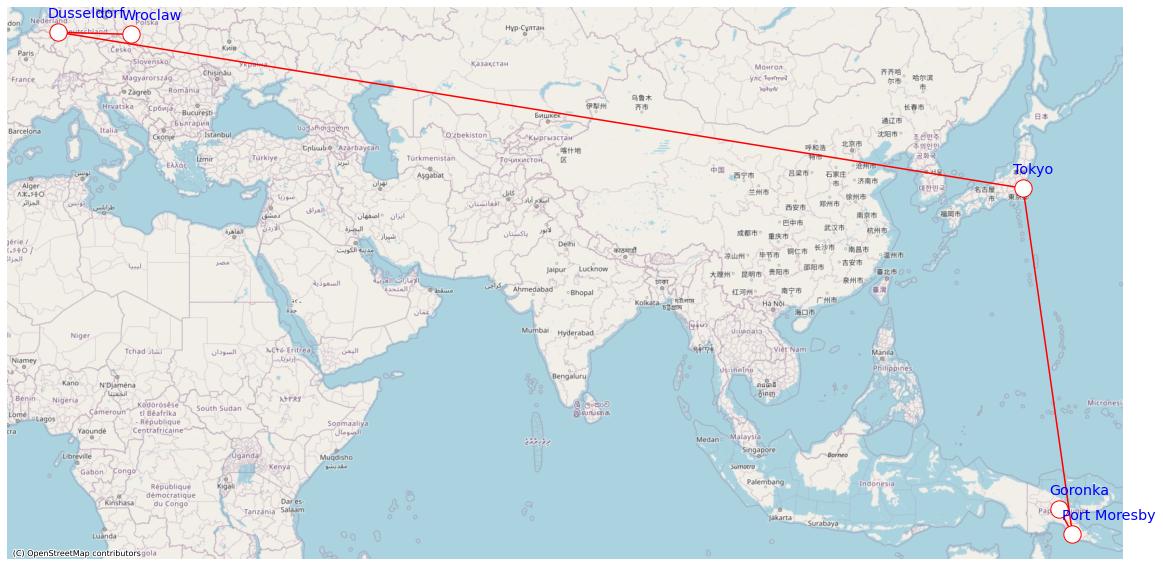

In [15]:
fig_shortest_path=dfg_shortest_path_hops.to_crs(epsg=3857).plot(
    figsize=(20, 15), zorder=3,
    alpha=1, color='w', edgecolor='r', markersize=300
)
fig_shortest_path.set_axis_off()

dfg_shortest_path_hops.to_crs(epsg=3857).apply(
    lambda port: fig_shortest_path.annotate(port.CITY, 
                                            xy=port.POINT_LON_LAT_GEO.coords[0], 
                                            xytext=(-10, 15), 
                                            textcoords="offset points",
                                            fontsize="x-large",
                                            color="b"
                                           ), axis=1
)

dfg_shortest_path_string.to_crs(epsg=3857).plot(ax=fig_shortest_path, alpha=1, edgecolor='r', zorder=1)

ctx.add_basemap(ax=fig_shortest_path, source=ctx.providers.OpenStreetMap.Mapnik)

## Shortest path (weighted)

...from **WRO** (Wrocław, Poland) to **GKA** (Goroka, Papua New Guinea) with the shortest distance

In [16]:
path_wro_to_gka_dist=hgws_airroutes.shortest_path(
    source=str(hgws_airroutes.vertices_hdf.filter("CODE='WRO'").select('ID').collect().values[0][0]),
    target=str(hgws_airroutes.vertices_hdf.filter("CODE='GKA'").select('ID').collect().values[0][0]),
    direction='OUTGOING', 
    weight='DIST'
)

print("Total distance: {}".format(int(path_wro_to_gka_dist.weight())))
# display(path_wro_to_gka_dist.edges().set_index('EDGE_ORDER'))
# display(path_wro_to_gka_dist.vertices().set_index('VERTEX_ORDER'))

Total distance: 8730


In [17]:
dfg_shortest_path_dist_hops = geopandas.GeoDataFrame(
    dfh_ports
    .filter('ID IN ('+path_wro_to_gka_dist.vertices().ID.astype(str).str.cat(sep=',')+')')
    .select("ID", "CODE", "CITY", "POINT_LON_LAT_GEO").collect(), 
    geometry='POINT_LON_LAT_GEO', crs="EPSG:4326"
)

dfg_shortest_path_dist_string = geopandas.GeoDataFrame(
cchc.sql(dfh_routes_strings
         .filter('ID IN ('+path_wro_to_gka_dist.edges().ID.astype(str).str.cat(sep=',')+')')
         .agg([('ST_UnionAggr', 'LINE', 'LINE_PATH')])
         .select_statement, 
        geo_cols={'LINE_PATH':4326}).collect(), geometry='LINE_PATH', crs="EPSG:4326")

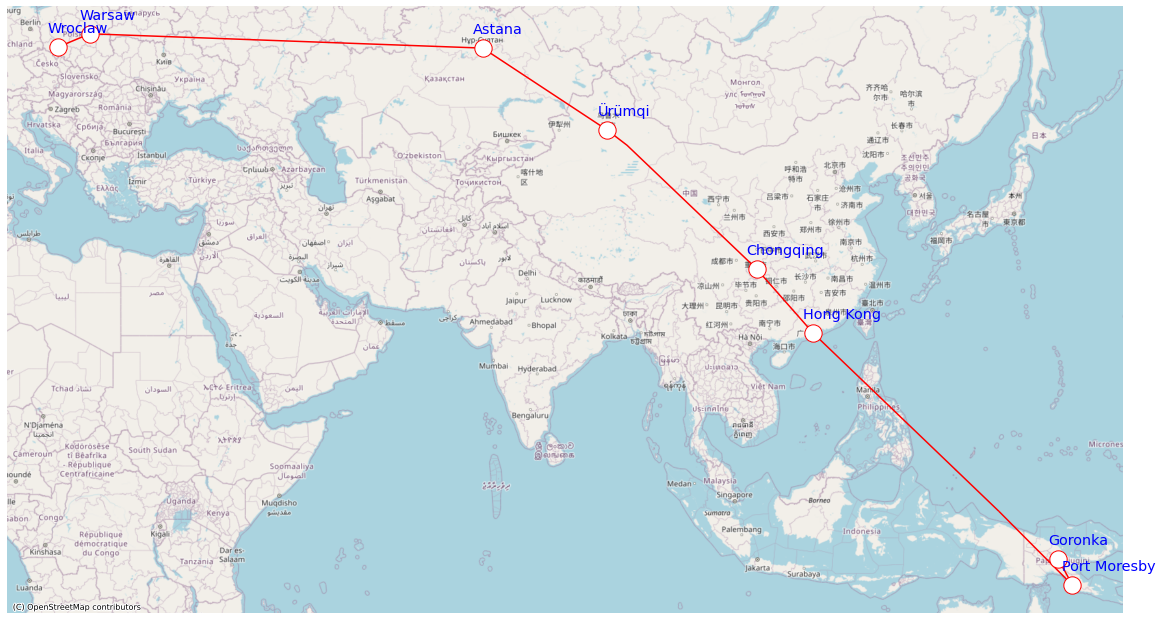

In [18]:
fig_shortest_path_dist=dfg_shortest_path_dist_hops.to_crs(epsg=3857).plot(
    figsize=(20, 15), zorder=3,
    alpha=1, color='w', edgecolor='r', markersize=300
)
fig_shortest_path_dist.set_axis_off()

dfg_shortest_path_dist_hops.to_crs(epsg=3857).apply(
    lambda port: fig_shortest_path_dist.annotate(port.CITY, 
                                            xy=port.POINT_LON_LAT_GEO.coords[0], 
                                            xytext=(-10, 15), 
                                            textcoords="offset points",
                                            fontsize="x-large",
                                            color="b"
                                           ), axis=1
)

dfg_shortest_path_dist_string.to_crs(epsg=3857).plot(ax=fig_shortest_path_dist, alpha=1, edgecolor='r', zorder=1)

ctx.add_basemap(ax=fig_shortest_path_dist, source=ctx.providers.OpenStreetMap.Mapnik)

# That's all for now!